## Pregunta 3 Reconocimiento de Imágenes en CIFAR10

#### Se extraen los diccionarios

In [2]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### a) Creación de los conjuntos de datos

In [3]:
from scipy.misc import imread
import cPickle as pickle
import numpy as np
import os
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

def load_CIFAR_one(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f)
        X = datadict['data']
        Y = datadict['labels']
        return X, np.array(Y, dtype=int)

def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtemp = np.concatenate(xs)
    Ytemp = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, 'test_batch'))
    Xtr, Xv, Ytr, Yv = train_test_split(Xtemp, Ytemp, test_size=0.2, random_state=0)
    del Xtemp, Ytemp
    return Xtr, Ytr, Xte, Yte, Xv, Yv
#you need to add Xval
Xtr, Ytr, Xte, Yte, Xv, Yv = load_CIFAR10('.')

### b) Escalamiento

In [4]:
from sklearn.preprocessing import StandardScaler

def scaler_function(Xtr,Xt,Xv,scale=True):
    scaler = StandardScaler(with_std=scale).fit(Xtr)
    Xtr_scaled = scaler.transform(Xtr)
    Xt_scaled = scaler.transform(Xt)
    Xv_scaled = scaler.transform(Xv)
    return Xtr_scaled, Xt_scaled, Xv_scaled

Xtr, Xte, Xv = scaler_function(Xtr,Xte,Xv)

from keras.utils.np_utils import to_categorical

Ytr = to_categorical(Ytr)
Yte = to_categorical(Yte)
Yv = to_categorical(Yv)

Using Theano backend.


### c) Red Neuronal

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

def do_red_neuronal(Xtr, Ytr, Xte, Yte, Xv, Yv):
    model = Sequential()
    model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(10, init='uniform', activation='softmax'))
    model.compile(optimizer=SGD(lr=0.05), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
    
    scores = model.evaluate(Xtr, Ytr)
    train_acc = scores[1]
    scores = model.evaluate(Xv, Yv)
    val_acc = scores[1]
    scores = model.evaluate(Xte, Yte)
    test_acc = scores[1]
    
    print "\nAccuracy de train: %f"%(train_acc)
    print "Accuracy de validacion: %f"%(val_acc)
    print "Accuracy de test: %f"%(test_acc)

In [5]:
do_red_neuronal(Xtr, Ytr, Xte, Yte, Xv, Yv)   

10000/10000 [==============================] - 0s     

Accuracy de train: 0.954353
Accuracy de validacion: 0.916450
Accuracy de test: 0.914510


### d) Red Neuronal: extract_features

In [6]:
Xtr, Ytr, Xte, Yte, Xv, Yv = load_CIFAR10('.')
Ytr = to_categorical(Ytr)
Yte = to_categorical(Yte)
Yv = to_categorical(Yv)

#### Feature: Histograma de Tono

In [10]:
from top_level_features import color_histogram_hsv
from top_level_features import hog_features
from top_level_features import extract_features
features_train = extract_features(Xtr,[color_histogram_hsv]) #extrae histogramas de color
features_test = extract_features(Xte,[color_histogram_hsv]) #extrae histogramas de color
features_val = extract_features(Xv,[color_histogram_hsv]) #extrae histogramas de color

print Xtr.shape
print features_train.shape

(40000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)


In [14]:
#features_train, features_test, features_val = scaler_function(features_train,features_test,features_val)

In [11]:
do_red_neuronal(features_train, Ytr, features_test, Yte, features_val, Yv)

 9664/10000 [===========================>..] - ETA: 0s
Accuracy de train: 0.900000
Accuracy de validacion: 0.900000
Accuracy de test: 0.900000


#### Feature: Descriptores HOG

In [12]:
features_train = extract_features(Xtr,[hog_features]) #extrae hog features
features_test = extract_features(Xte,[hog_features]) #extrae hog features
features_val = extract_features(Xv,[hog_features]) #extrae hog features

print Xtr.shape
print features_train.shape

(40000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)
(40000L, 3072L)
(40000L, 144L)


In [13]:
do_red_neuronal(features_train, Ytr, features_test, Yte, features_val, Yv)

 9824/10000 [============================>.] - ETA: 0s
Accuracy de train: 0.939175
Accuracy de validacion: 0.923140
Accuracy de test: 0.923400


#### Feature: Híbrido (HOG e Histograma)

In [14]:
features_train = extract_features(Xtr,[hog_features, color_histogram_hsv]) #extrae todo
features_test = extract_features(Xte,[hog_features, color_histogram_hsv]) #extrae todo
features_val = extract_features(Xv,[hog_features, color_histogram_hsv]) #extrae todo

print Xtr.shape
print features_train.shape

(40000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)
(40000L, 3072L)
(40000L, 154L)


In [50]:
#features_train, features_test, features_val = scaler_function(features_train,features_test,features_val)

In [15]:
do_red_neuronal(features_train, Ytr, features_test, Yte, features_val, Yv)

 9856/10000 [============================>.] - ETA: 0s
Accuracy de train: 0.941618
Accuracy de validacion: 0.925220
Accuracy de test: 0.925630


### e) SVM No-Lineal

En primer lugar se debe resaltar que Kenalizar una SVM tiene un costo elevado de aproximadamente $O(n_{features}× n^{2}_{data})$. Además en la documentación de sklearn expecifica que para data sets con más de 10000 datos es difícil de escalar ([scikit-learn: SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)). Lo cual vuelve inviable la utilizan de una SVM no lineal en este problema, ya que se tienen 40000 datos de entrenamiento y 3072 caráctiristicas. Por lo tanto se opto por reducir el conjunto de datos a 10000.

In [5]:
Xtr, Ytr, Xte, Yte, Xv, Yv = load_CIFAR10('.')
Xtr= Xtr[0:10000]
Ytr = Ytr[0:10000]
Xtr, Xte, Xv = scaler_function(Xtr,Xte,Xv)

C:\Users\theda\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\theda\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\theda\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\theda\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
from sklearn.svm import SVC

def do_SVM_no_lineal(x,y,xt,yt,xv,yv,model_type,best):
    Cs = np.logspace(-2, 4,base=2, num=7)
    acc_val = []
    models = []
    for C in Cs:
        if model_type == 'rbf':
            clf = SVC(C=C, kernel='rbf')
        elif model_type == 'poly':
            clf = SVC(C=C, kernel='poly',degree=2, coef0=1)

        clf=clf.fit(x,y)
                
        acc_val.append(clf.score(xv,yv))
        models.append(clf)

    if best:
        best_ = acc_val.index(max(acc_val))
        C_b = Cs[best_]
        model_b = models[best_]
        print "Mejor parámetro de regularización C: %s"%(C_b)
        print "Mejor Accuracy de validación: %f"%(max(acc_val))
        print "\nAccuracy de entrenamiento: %f"%(model_b.score(x,y))
        print "Accuracy de prueba: %f"%(model_b.score(xt,yt))
        
        plt.figure(figsize=(10,5))
        ax = plt.gca()
        #ax.plot(Cs,acc_tr,label='Accuracy train')
        ax.plot(Cs,acc_val,label=u'Accuracy validación')
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.xlabel('C', fontsize= 16)
        plt.ylabel('Accuracy', fontsize= 16)
        plt.title('SVM no Lineal con kernel %s'%(model_type), fontsize= 20)
        ax.set_xscale('linear')
        plt.show()
        
    return 0

Mejor parámetro de regularización C: 4.0
Mejor Accuracy de validación: 0.489700

Accuracy de entrenamiento: 0.957200
Accuracy de prueba: 0.487100


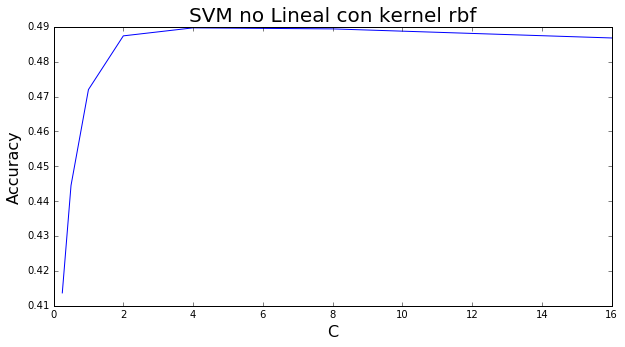

SVC(C=4.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [8]:
do_SVM_no_lineal(Xtr, Ytr, Xte, Yte, Xv, Yv, 'rbf', best=True)

In [ ]:
do_SVM_no_lineal(Xtr, Ytr, Xte, Yte, Xv, Yv, 'poly', best=True)

#### Feature: Histograma de Tono

In [ ]:
features_train = extract_features(Xtr,[color_histogram_hsv]) #extrae histogramas de color
features_test = extract_features(Xte,[color_histogram_hsv]) #extrae histogramas de color
features_val = extract_features(Xv,[color_histogram_hsv]) #extrae histogramas de color

In [ ]:
do_SVM_no_lineal(features_train, Ytr, features_test, features_val, Xv, Yv, 'rbf', best=True)
#do_SVM_no_lineal(features_train, Ytr, features_test, features_val, Xv, Yv, 'poly', best=True)

#### Feature: Descriptores HOG

In [ ]:
features_train = extract_features(Xtr,[hog_features]) #extrae hog features
features_test = extract_features(Xte,[hog_features]) #extrae hog features
features_val = extract_features(Xv,[hog_features]) #extrae hog features

In [ ]:
do_SVM_no_lineal(features_train, Ytr, features_test, features_val, Xv, Yv, 'rbf', best=True)
#do_SVM_no_lineal(features_train, Ytr, features_test, features_val, Xv, Yv, 'poly', best=True)

#### Feature: Híbrido (HOG e Histograma)

In [ ]:
features_train = extract_features(Xtr,[hog_features, color_histogram_hsv]) #extrae todo
features_test = extract_features(Xte,[hog_features, color_histogram_hsv]) #extrae todo
features_val = extract_features(Xv,[hog_features, color_histogram_hsv]) #extrae todo

In [ ]:
do_SVM_no_lineal(features_train, Ytr, features_test, features_val, Xv, Yv, 'rbf', best=True)
do_SVM_no_lineal(features_train, Ytr, features_test, features_val, Xv, Yv, 'poly', best=True)

#### SVM son Inviables o.ó

### Árbol de clasificación

In [19]:
Xtr, Ytr, Xte, Yte, Xv, Yv = load_CIFAR10('.')

In [20]:
from sklearn.tree import DecisionTreeClassifier as Tree

def do_Tree(x,y,xt,yt,xv,yv):
    N_ts = np.linspace(2, 20, num=20)
    acc_val = []
    models = []
    for n_t in N_ts:
        clf=Tree(criterion='gini',splitter='best',random_state=0,max_depth=n_t)
        clf=clf.fit(x,y)
        acc_val.append(clf.score(xv,yv))
        models.append(clf)
    best_ = acc_val.index(max(acc_val))            
    model_best = models[best_]
    
    print "Profundidad del mejor árbol = %d"%model_best.tree_.max_depth
    print "Mejor Accuracy de validación: %f"%(max(acc_val))
    print "\nAccuracy de entrenamiento: %f"%(model_best.score(x,y))
    print "Accuracy de prueba: %f"%(model_best.score(xt,yt))
    
    plt.figure(figsize=(10,5))
    ax = plt.gca()
    #ax.plot(N_ts,acc_tr,label='Accuracy train')
    ax.plot(N_ts,acc_val,label=u'Accuracy validación')

    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('N_t', fontsize= 16)
    plt.ylabel('Accuracy', fontsize= 16)
    plt.title(u'Árbol de clasificacion con múltiples niveles', fontsize= 20)
    ax.set_xscale('linear')
    plt.show()
        
    return 0

Profundidad del mejor árbol = 9
Mejor Accuracy de validación: 0.298300

Accuracy de entrenamiento: 0.390000
Accuracy de prueba: 0.302000


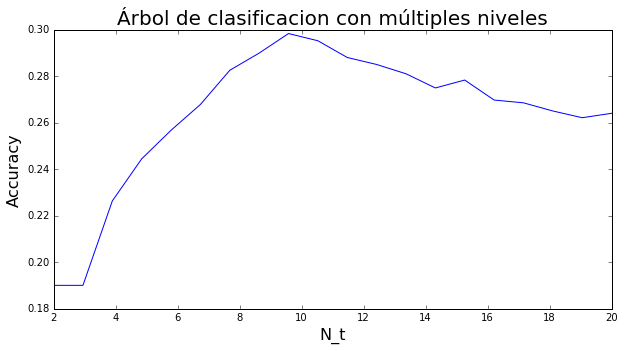

0

In [21]:
do_Tree(Xtr, Ytr, Xte, Yte, Xv, Yv)

#### Feature: Histograma de Tono

In [ ]:
features_train = extract_features(Xtr,[color_histogram_hsv]) #extrae histogramas de color
features_test = extract_features(Xte,[color_histogram_hsv]) #extrae histogramas de color
features_val = extract_features(Xv,[color_histogram_hsv]) #extrae histogramas de color

In [ ]:
do_Tree(features_train, Ytr, features_test, Yte, features_val, Yv)

#### Feature: Descriptores HOG

In [ ]:
features_train = extract_features(Xtr,[hog_features]) #extrae hog features
features_test = extract_features(Xte,[hog_features]) #extrae hog features
features_val = extract_features(Xv,[hog_features]) #extrae hog features

In [ ]:
do_Tree(features_train, Ytr, features_test, Yte, features_val, Yv)

#### Feature: Híbrido (HOG e Histograma)

In [ ]:
features_train = extract_features(Xtr,[hog_features, color_histogram_hsv]) #extrae todo
features_test = extract_features(Xte,[hog_features, color_histogram_hsv]) #extrae todo
features_val = extract_features(Xv,[hog_features, color_histogram_hsv]) #extrae todo

In [ ]:
do_Tree(features_train, Ytr, features_test, Yte, features_val, Yv)